# Demo de creación de Deep Fakes de imágenes con Deep Autoencoder (DAE)
Aplica la propuesta de:

https://www.researchgate.net/publication/349703826_Deepfakes_Generation_and_Detection_State-of-the-art_open_challenges_countermeasures_and_way_forward

https://www.codeproject.com/Articles/5298025/Building-and-Training-Deep-Fake-Autoencoders


# Preparación:

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import random
import copy
import math

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import display, clear_output

import cv2
from PIL import Image

import os
import csv

print("\nLibrerías importadas")


Librerías importadas


In [ ]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


In [ ]:
#@title Cargar imágenes


#@markdown ### Parámetros para imágenes:
imagen_ancho = 32 #@param {type:"integer"}
imagen_largo = 32 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
incluir_imagenes_generadas_con_data_augmentation = False #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))


# define tamaño de datos de entrada
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# indica si se usan las imágenes generadas por data augmentation
usarDA = incluir_imagenes_generadas_con_data_augmentation


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

clasesList = list( os.listdir( imagPath_train ) )
clasesList.sort()
claseSelecc = widgets.SelectMultiple(
  options=clasesList,
  value=([clasesList[0], clasesList[1]] if len(clasesList)>=2 else []),
  description='Clases a cargar:')

# define función para cargar las imágenes
def cargarImagenes(imagPath, clasesFiltrar=None):
  classes_ori = []
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

    if (clasesFiltrar is None) or (each_dir in clasesFiltrar):

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')

            if usarDA or (not esImagDA):

                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)

                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:
                  tipoImage = 'L'
                else:
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

                # transforma a un vector de nros
                arImag = np.array(imag)

                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

ui = widgets.VBox([claseSelecc])

# inicializa las variables
classes_train, images_train, esDAimag_train, tipoImage_train = [], [], [], []
classes_test, images_test, esDAimag_test, tipoImage_test = [], [], [], []
listClases = []

# realiza cambio de selección
def cambiaSeleccion(clasesFiltrar):
  global classes_train, images_train, esDAimag_train, tipoImage_train
  global classes_test, images_test, esDAimag_test, tipoImage_test
  global listClases

  listClases = list(clasesFiltrar)
  # carga las imagenes de entrenamiento
  classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train, clasesFiltrar)
  print("> Para Entrenamiento: ")
  print("- Clases cargadas: ", len(np.unique(classes_train)))
  print("- Imágenes cargadas: ", len(classes_train))

  if len(classes_train)>0:
    print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  # carga las imagenes de prueba
  classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test, clasesFiltrar)
  print("\n\n> Para Prueba: ")
  print("- Clases cargadas: ", len(np.unique(classes_test)))
  print("- Imágenes cargadas: ", len(images_test))

  if len(classes_test)>0:
    print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )


out = widgets.interactive_output(cambiaSeleccion, {'clasesFiltrar': claseSelecc})
display(ui, out)




Output()

In [ ]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (96, 3072)
	clase 0: 48
	clase 1: 48
 - y_trainEnc (cant):  96
 - y_train (cant):  96


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (24, 3072)
	clase 0: 48
	clase 1: 48
 - y_testEnc (cant):  24
 - y_test (cant):  24


> Para Ambos: 
 - dictMapeo:  {'0': 0, '1': 1}
 - CLASES:  ['0', '1']

 - Imagen reconstruida de  0 ( 0  /  [1. 0.] )


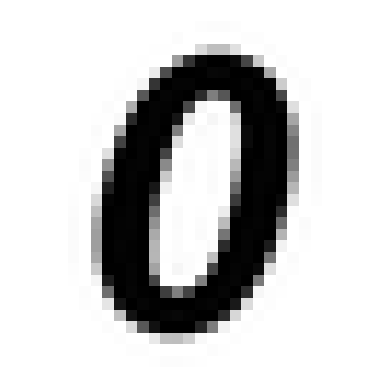

In [ ]:
#@title Preparar imágenes para usar en el modelo

def agregarRuidoImagen(x_datos, gradoRuido):
  # copia datos para no cambiar original
  x_datos = copy.deepcopy(x_datos)
  # si es negativo, determina el grado al azar
  if gradoRuido < 0:
    gradoRuido = random.randint(0, 100)
  # agrega ruido al azar
  x_datos = x_datos + np.random.normal(loc=0.0, scale=gradoRuido/100, size=x_datos.shape)
  x_datos = np.clip(x_datos, 0., 1.)
  return x_datos

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList, imagClass, normValores=True):
  auxiAr = np.array(imagList)
  if normValores:
    auxiAr = auxiAr.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))
  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  x = [ [] for _ in range(len(classesList)) ]
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vaores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

def separarImagenesPorClase(listClases, x, y):
  aux_listClase = [ [] for _ in listClases]
  for im, cl in zip(x, y):
    aux_listClase[cl].append( im )
  return aux_listClase

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train, y_train)
x_test = prepare_imageList(images_test, y_test)

daLayers_modelo = []

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
CLASES = [ x for x, y in dictMapeo.items() ]

# realiza la separación de los datos por clase
xtrain_listClase = separarImagenesPorClase(listClases, x_train, y_train)
xtest_listClase = separarImagenesPorClase(listClases, x_train, y_train)

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
for cl in listClases:
  print("\tclase " + str(cl) + ":", (len( xtrain_listClase[dictMapeo[cl]] )) )
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
for cl in listClases:
  print("\tclase " + str(cl) + ":", (len( xtest_listClase[dictMapeo[cl]] )) )
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - CLASES: ", CLASES)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", CLASES[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])



---
# Construcción de Deep AutoEncoder:


Modelo DAE-DF creado para clase 0 con  11  capas:
Model: "cl0_DAE_DeepFake"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 3072)]            0         
                                                                 
 enc_1 (Dense)               (None, 512)               1573376   
                                                                 
 enc_2 (Dense)               (None, 128)               65664     
                                                                 
 enc_3 (Dense)               (None, 64)                8256      
                                                                 
 enc_4 (Dense)               (None, 16)                1040      
                                                                 
 features (Dense)            (None, 8)                 136       
                                                                 


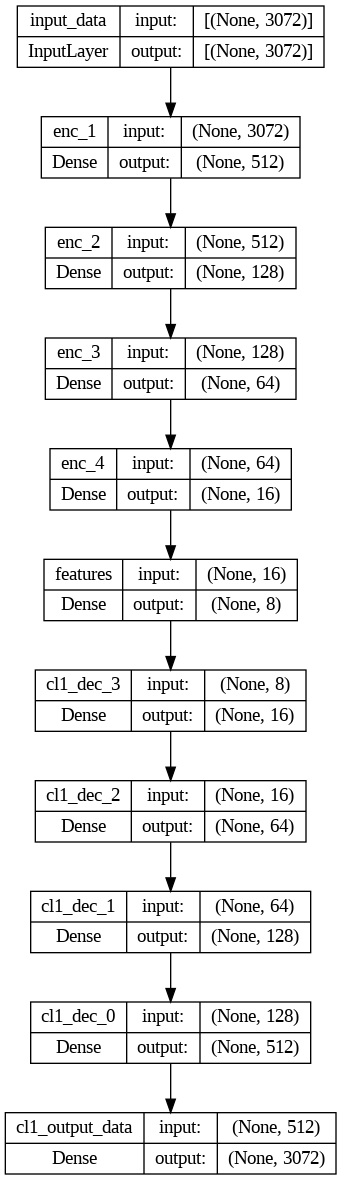

In [ ]:
#@title Establecer el modelo DAE para DeepFake

#@markdown ### Parámetros de la Red:
rna_cant_neuronas_capas_ocultas = '512, 128, 64,16' #@param {type:"string"}
rna_neuronas_funcion_activacion = "relu" #@param ["linear", "relu", "sigmoid", "tanh"]
rna_cant_neuronas_capa_features = 8 #@param {type:"integer"}

#@markdown ### Parámetros para ayudar aprender a capas Encoder:
rna_valor_L1_activity_regularizer = False #@param {type:"boolean"}
#@markdown (Nota: si se indica verdadero, se agrega la restricción de las representaciones para que sean compactas en capas de Encoders - nunca en Decoders)

rna_porc_capa_DropOut = 0.0 #@param {type:"number"}
#@markdown (Nota: si se indica valor mayor a cero, se agregan capas DropOut en capas de Encoders - nunca en Decoders)

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

# define tamaño de datos de entrada y salida
num_outputs = num_inputs

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
if rna_cant_neuronas_capa_features < 1:
  num_features = 1
else:
  num_features = rna_cant_neuronas_capa_features

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.legacy.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.legacy.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.legacy.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.legacy.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.legacy.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.legacy.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.legacy.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# cantidad de neuronas ocultas para la parte Encoder
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers_shared = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  dae_layers_shared.append( int(val) )

#  agrega la capa de features a las capas
dae_layers_shared.append( num_features )

# cantidad de neuronas ocultas para la parte Decoder
#   (usa la la lista de Encoder inversa)
dae_layers_out = []
for eachEncLayer in dae_layers_shared[0:len(dae_layers_shared)-1][::-1]:
  dae_layers_out.append( eachEncLayer )

if rna_porc_capa_DropOut > 0.9:
  rna_porc_capa_DropOut = 0.9

# define la arquitectura de capas del Deep Autoencoder común para todos los sub-modelos
# teniendo en cuenta la definición dada anteriomente
input_data_Lay = tf.keras.layers.Input(shape=(num_inputs,), name='input_data') # capa de entrada
eachLay = input_data_Lay
auxName = 'enc_'
auxId = 1
for num_hid in dae_layers_shared:

    # define el nombre de la capa oculta
    actReg_Dense = None
    if num_features==num_hid:
        # capa tipo Features
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          # capa tipo Encoder
          auxId = auxId + 1
          if rna_valor_L1_activity_regularizer:
            # agrega regulizer
            actReg_Dense = tf.keras.regularizers.l1(10e-5)
        else:
          # capa tipo Decoder
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = tf.keras.layers.Dense(num_hid,
                                    activation = rna_neuronas_funcion_activacion,
                                    activity_regularizer = actReg_Dense,
                                    name = auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      # guarda capa Features
      features_Lay = eachLay

    # agrega capa Drop si es Encoder y se indica probabilidad > 0
    if (rna_porc_capa_DropOut>0.0) and (auxName == 'enc_'):
      eachLay = tf.keras.layers.Dropout(rna_porc_capa_DropOut,
                                        name = auxlayerName+"_dp")(eachLay)

# define la arquitectura de capas del Deep Autoencoder para salida por clase
# teniendo en cuenta la definición dada anteriomente
DAEModels_DictClase = {}
auxId_ori = auxId
for modelClase in listClases:
    nombreClase = "cl" + str(modelClase) + "_"
    # recupera originales
    auxId = auxId_ori
    actReg_Dense = None
    eachLay = features_Lay

    for num_hid in dae_layers_out:
        # capa tipo Decoder
        auxId = auxId - 1

        auxlayerName = nombreClase+auxName+str(auxId)

        # agrega la capa oculta
        eachLay = tf.keras.layers.Dense(num_hid,
                                        activation = rna_neuronas_funcion_activacion,
                                        activity_regularizer = actReg_Dense,
                                        name = auxlayerName)(eachLay) # capas ocultas

    rna_salida_funcion_activacion = "sigmoid"

    # capa de salida
    auxOutName = nombreClase+'output_data'
    output_data_Lay = tf.keras.layers.Dense(num_outputs,
                                            activation = rna_salida_funcion_activacion,
                                            name=auxOutName)(eachLay) # capa de salida

    # genera el modelo Deep Autoencoder para la clase
    DAEmodel = Model(input_data_Lay, output_data_Lay, name=nombreClase+'DAE_DeepFake')

    # dependiendo de la función de la capa de salida y si son imágenes con color
    # determinar cómo se calcula el loss
    if imagen_color and (rna_salida_funcion_activacion == "sigmoid"):
      lossFunc = "mse"
    else:
      lossFunc = "binary_crossentropy"

    DAEmodel.compile(optimizer=opt, loss=[lossFunc, lossFunc], metrics=['RootMeanSquaredError'])

    print("Modelo DAE-DF creado para clase " + str(modelClase) + " con ", len(DAEmodel.layers), " capas:")
    DAEmodel.summary()
    # agrega modelo por clase
    DAEModels_DictClase[modelClase] = DAEmodel
    print("\n")

# muestra último
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)


In [ ]:
#@title Entrenar DAE para DeepFake

cant_ciclos_entrenamiento_general = 5 #@param {type:"integer"}
cant_epocas_entrenamiento_por_ciclo = 100 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantCiclos = (1 if cant_ciclos_entrenamiento_general<1 else cant_ciclos_entrenamiento_general)
cantEpocas = (1 if cant_epocas_entrenamiento_por_ciclo<1 else cant_epocas_entrenamiento_por_ciclo)

# entrena N ciclos usando M épocas por cada modelo clase
history_DictClase = {}
for i in range(cantCiclos):
  for modelClase in listClases:
    # determina modelo a entreanar
    DAEmodelClase = DAEModels_DictClase[modelClase]
    x_trainClase = np.array(xtrain_listClase[dictMapeo[modelClase]])
    # entrena
    descCicloModelo = "Ciclo #" + str(i+1) + "-" + DAEmodelClase.name
    print("\n> Entrena " + descCicloModelo)
    history = DAEmodelClase.fit(x_trainClase, x_trainClase,
                    epochs = cantEpocas,
                    shuffle = True)
    if DAEmodelClase.name not in history_DictClase:
      history_DictClase[DAEmodelClase.name] = {}
      history_DictClase[DAEmodelClase.name]["loss"] = []
      history_DictClase[DAEmodelClase.name]["root_mean_squared_error"] = []
    history_DictClase[DAEmodelClase.name]["loss"].extend( list(history.history["loss"]) )
    history_DictClase[DAEmodelClase.name]["root_mean_squared_error"].extend( list(history.history["root_mean_squared_error"]) )
    print("")



> Entrena Ciclo #1-cl0_DAE_DeepFake
Epoch 1/100
2/2 [==============================] - 4s 20ms/step - loss: 0.2289 - root_mean_squared_error: 0.4784
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 0.2212 - root_mean_squared_error: 0.4704
Epoch 3/100
2/2 [==============================] - 0s 8ms/step - loss: 0.1671 - root_mean_squared_error: 0.4088
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.0973 - root_mean_squared_error: 0.3119
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0872 - root_mean_squared_error: 0.2953
Epoch 6/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0858 - root_mean_squared_error: 0.2928
Epoch 7/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
Epoch 8/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0801 - root_mean_squared_error: 0.2831
Epoch 9/100
2/2 [==============================] - 0s 9ms/step

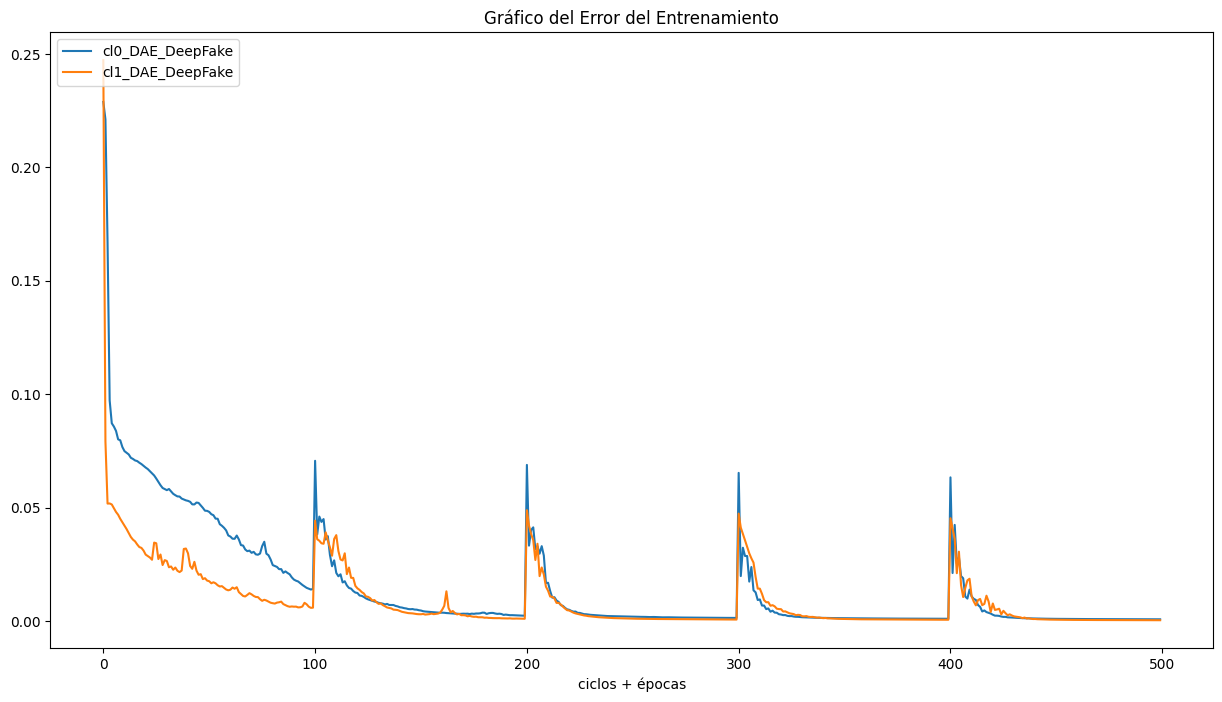

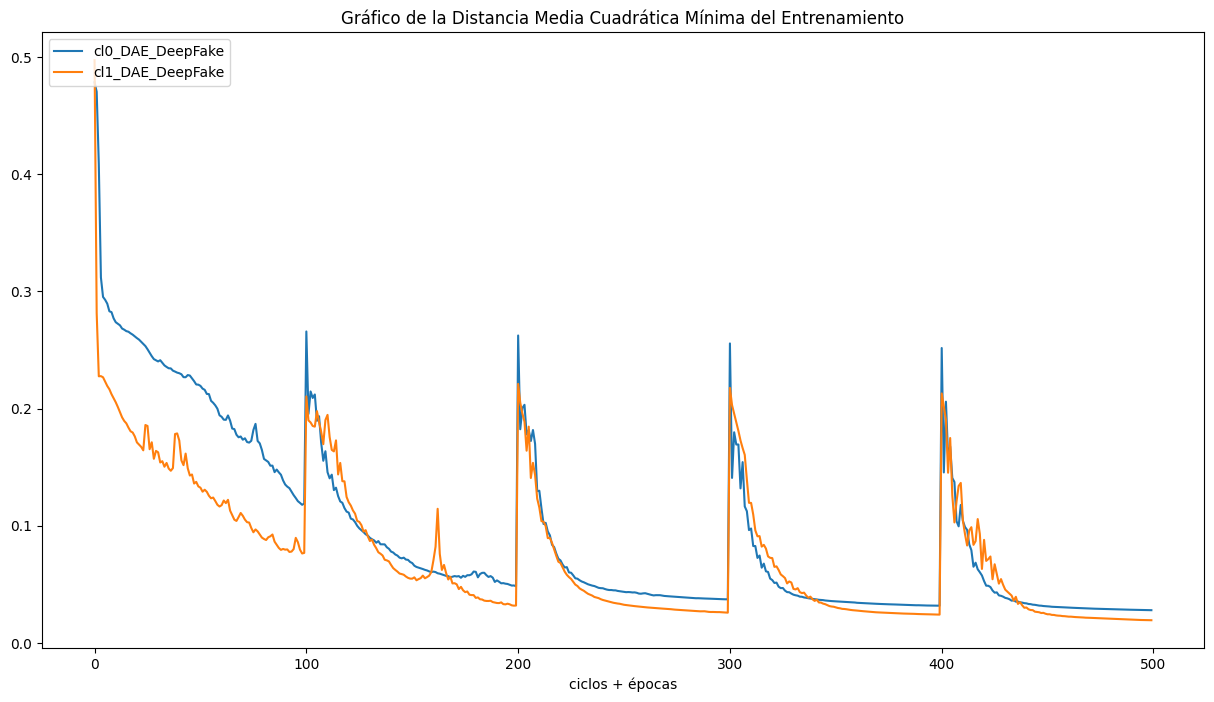

In [ ]:
#@title Mostrar Gráficos del Entrenamiento

auxLeyendas = list(history_DictClase.keys())

plt.figure(figsize=(15,8))
for l in auxLeyendas:
  plt.plot( history_DictClase[l]["loss"] )
plt.legend(auxLeyendas, loc='upper left')
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('ciclos + épocas')
plt.show()

plt.figure(figsize=(15,8))
for l in auxLeyendas:
  plt.plot( history_DictClase[l]["root_mean_squared_error"] )
plt.legend(auxLeyendas, loc='upper left')
plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
plt.ylabel('')
plt.xlabel('ciclos + épocas')
plt.show()

In [ ]:
#@title Evaluar el modelo con las imágenes de entrenamiento
from IPython.display import clear_output

# para sacar warning por cantidad de imágenes mostradas
plt.rcParams.update({'figure.max_open_warning': 0})

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_DAE(clImag, clModelList, x, cant_mostrar):
  # desordena las imágenes
  np.random.shuffle(x)

  # toma el modelo
  for clModel in clModelList:
    DAEmodel =  DAEModels_DictClase[clModel]

    # procesa las imágenes con el modelo
    reconstr_imgs = DAEmodel.predict(x, verbose=0)

    cantMostradas = 0
    for i in range(min(cant_mostrar, len(x))):
      # prepara para mostrar
      fig = plt.figure()
      if i == 0:
        fig.suptitle( " Modelo clase " +  clModel + " con Imágenes clase "+str(clImag) )

      # muestra la real
      ax1 = fig.add_subplot(121)
      plot_image( x[i] )

      # muestra la generada por el modelo
      ax2 = fig.add_subplot(122)
      plot_image( reconstr_imgs[i] )

      plt.tight_layout()
      fig = plt.gcf()
      cantMostradas = cantMostradas + 1
    if (cant_mostrar != cantMostradas):
      print("\n\t Cantidad imágenes mostradas: ", cantMostradas, "\n")
  plt.show()

# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModeloDAE(funcionCambiaSeleccion):
  # prepara combo para filtrar por clase
  seleccion_CLASES = []
  seleccion_CLASES.extend( CLASES )
  seleccion_CLASES.sort()

  if len(seleccion_CLASES)>=2:
    clDefectoIm = seleccion_CLASES[0]
    clDefectoModel = seleccion_CLASES[1]
  else:
    clDefectoIm = seleccion_CLASES[0]
    clDefectoModel = seleccion_CLASES[0]


  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  ImagCombo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefectoIm,
      description = 'Clase de las Imágenes:',
      style=style_3D,
      disabled = False,
  )

  ModelCombo_clase = widgets.SelectMultiple(
      options = seleccion_CLASES,
      value = seleccion_CLASES,
      description = 'Clase del Modelo:',
      style=style_3D,
      disabled = False,
  )

  cant_mostrar = widgets.Dropdown(
      options = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
      value = 1,
      description = 'Cantidad a mostrar:',
      style=style_3D,
      disabled = False,
  )

  prueba_ui = widgets.GridBox(children=[ImagCombo_clase, ModelCombo_clase, cant_mostrar],
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'clImag':ImagCombo_clase, 'clModelList':ModelCombo_clase, 'cant_mostrar':cant_mostrar})
  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(clImag, clModelList, cant_mostrar):
  if (clImag=="-") or (cant_mostrar<=0):
    return
  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Entrenamiento: ")
  # toma las imágenes
  x = np.array(xtrain_listClase[dictMapeo[clImag]])
  # ejecuta
  probarModelo_DAE(clImag, list(clModelList), x, cant_mostrar)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModeloDAE( cambiaSeleccion_clase_evaluar_imEntrenamiento )
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Clase de las Imágenes:', options=('0', '1'), style=DescriptionStyle(de…

Output()

In [ ]:
#@title Evaluar el modelo con las imágenes de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imPrueba(clImag, clModelList, cant_mostrar):
  if (clImag=="-") or (cant_mostrar<=0):
    return
  # prueba con los datos de entrenamiento
  print("*** Resultados con datos de Prueba: ")
  # toma las imágenes
  x = np.array(xtest_listClase[dictMapeo[clImag]])
  # ejecuta
  probarModelo_DAE(clImag, list(clModelList), x, cant_mostrar)

# muestra la interface
ev_prueba_ui, ev_prueba_out = crearUI_evaluarModeloDAE( cambiaSeleccion_clase_evaluar_imPrueba )
display(ev_prueba_ui, ev_prueba_out)


GridBox(children=(Dropdown(description='Clase de las Imágenes:', options=('0', '1'), style=DescriptionStyle(de…

Output()